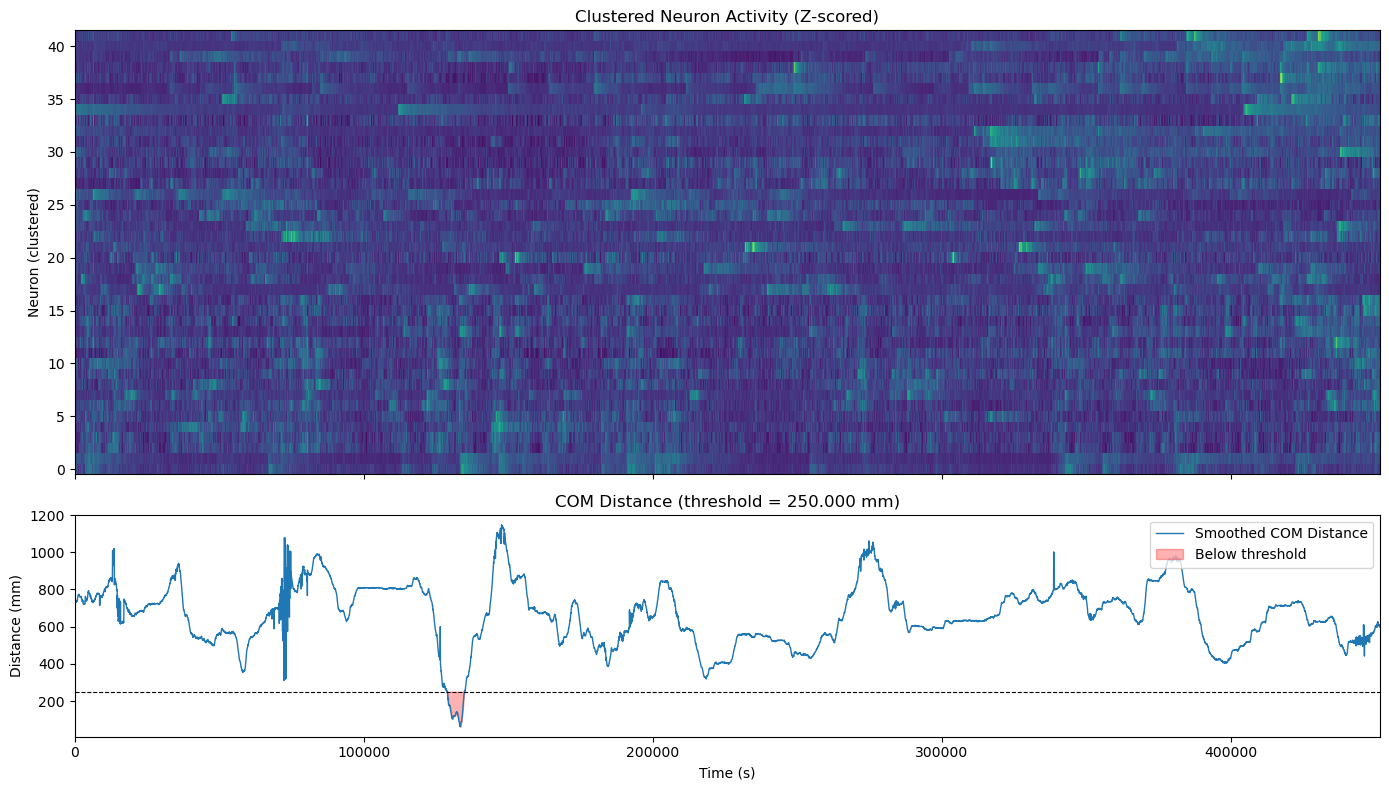

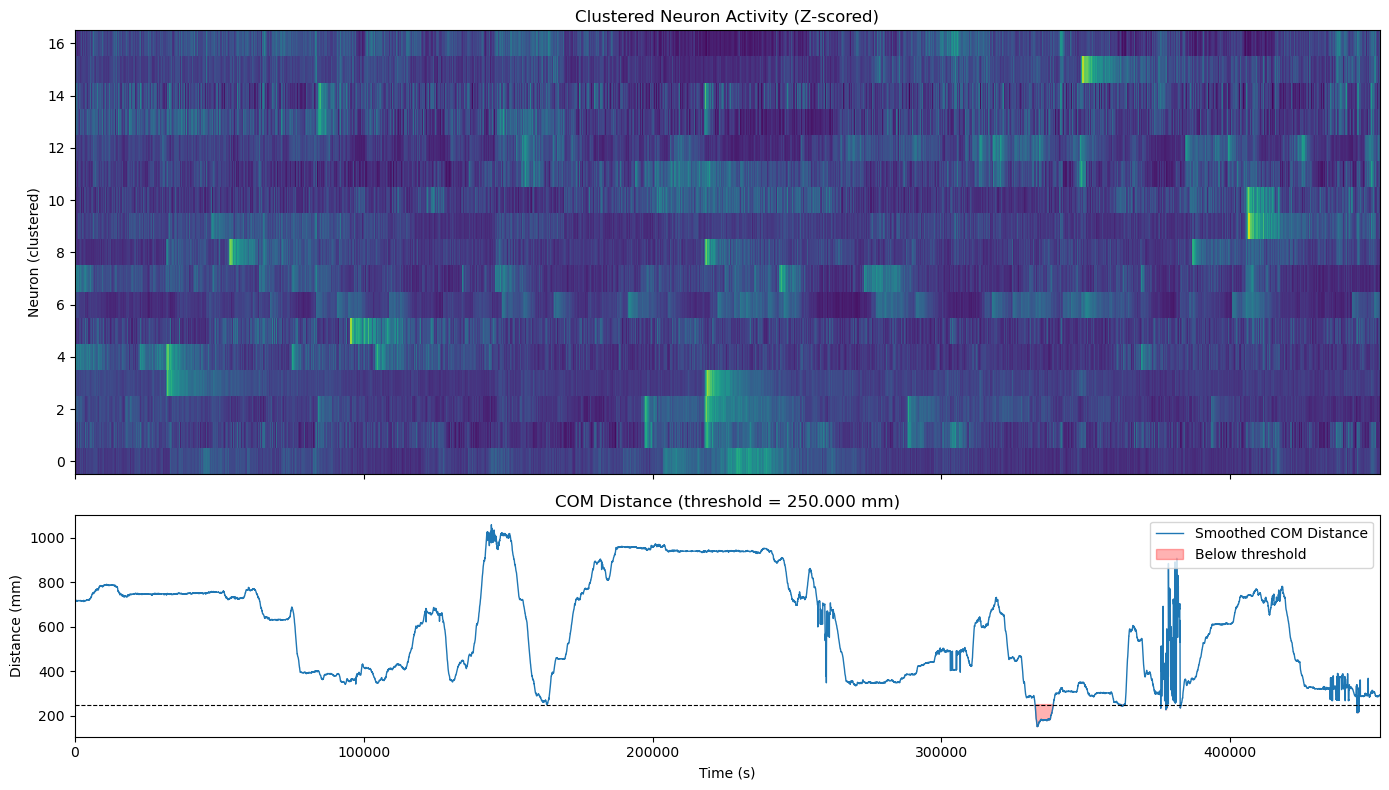

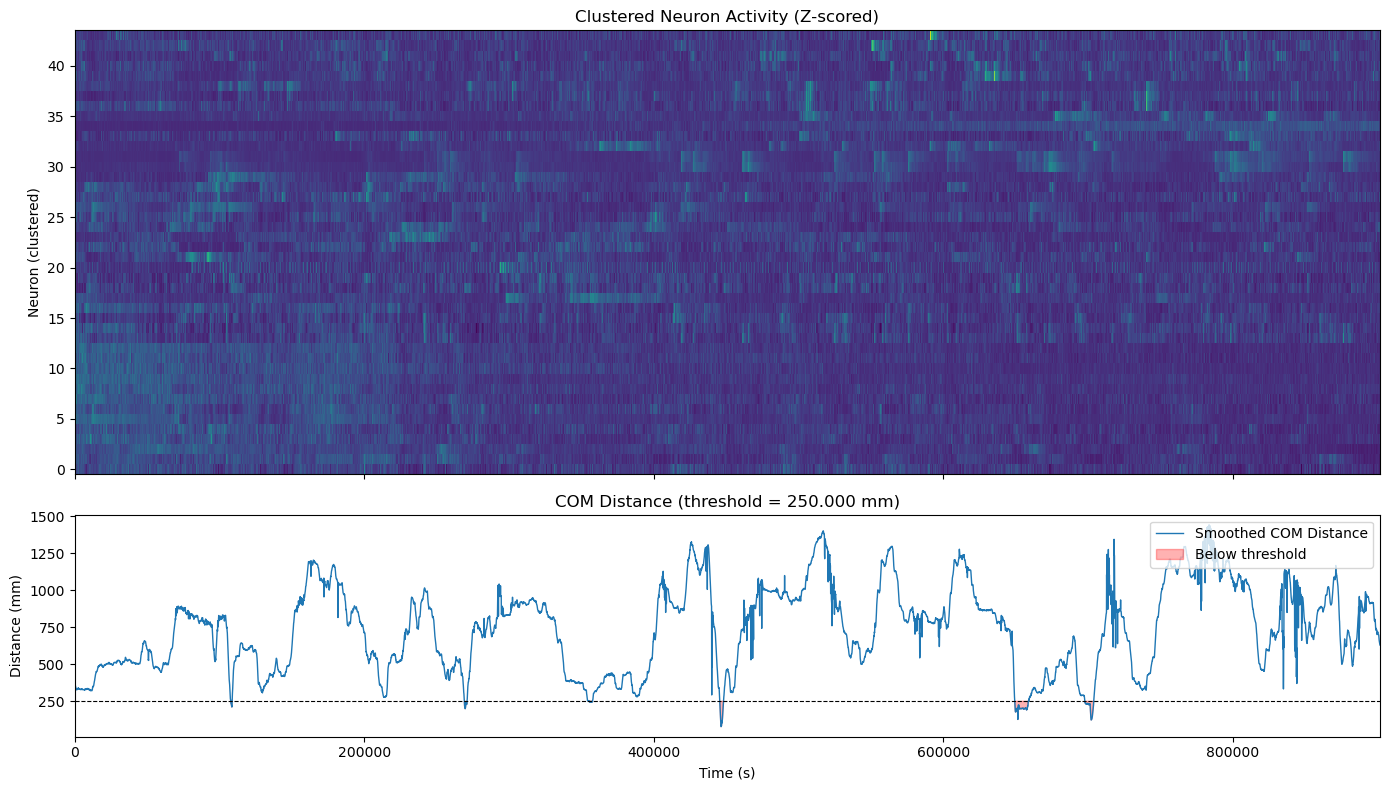

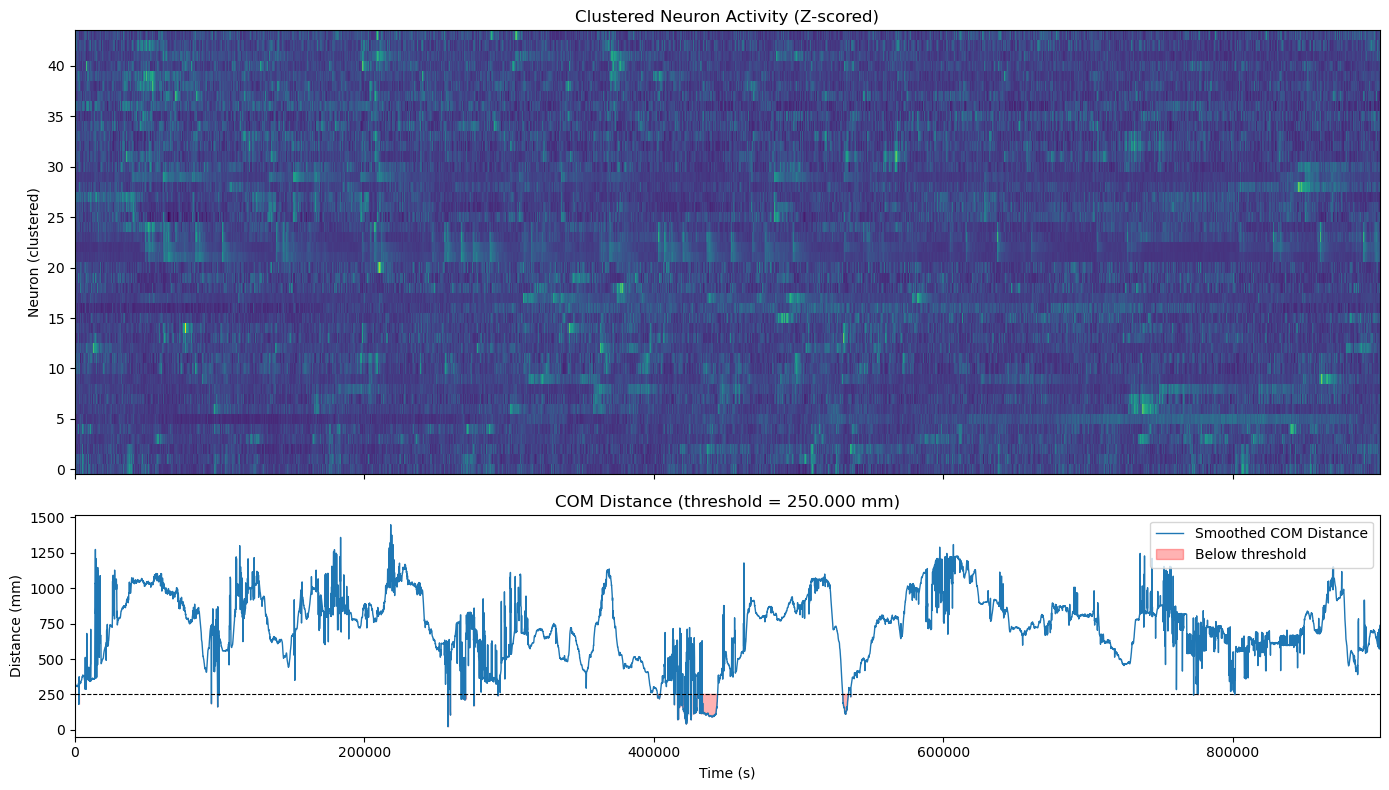

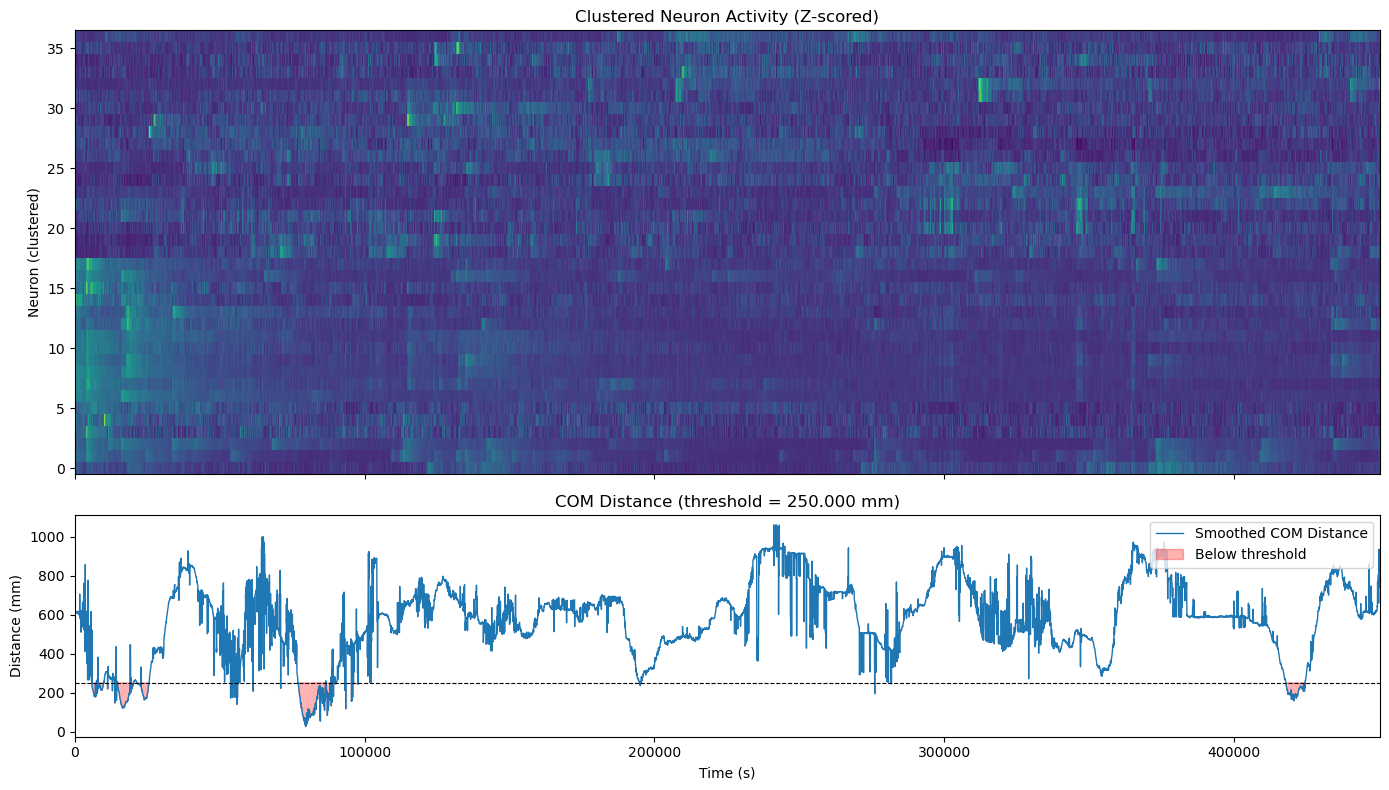

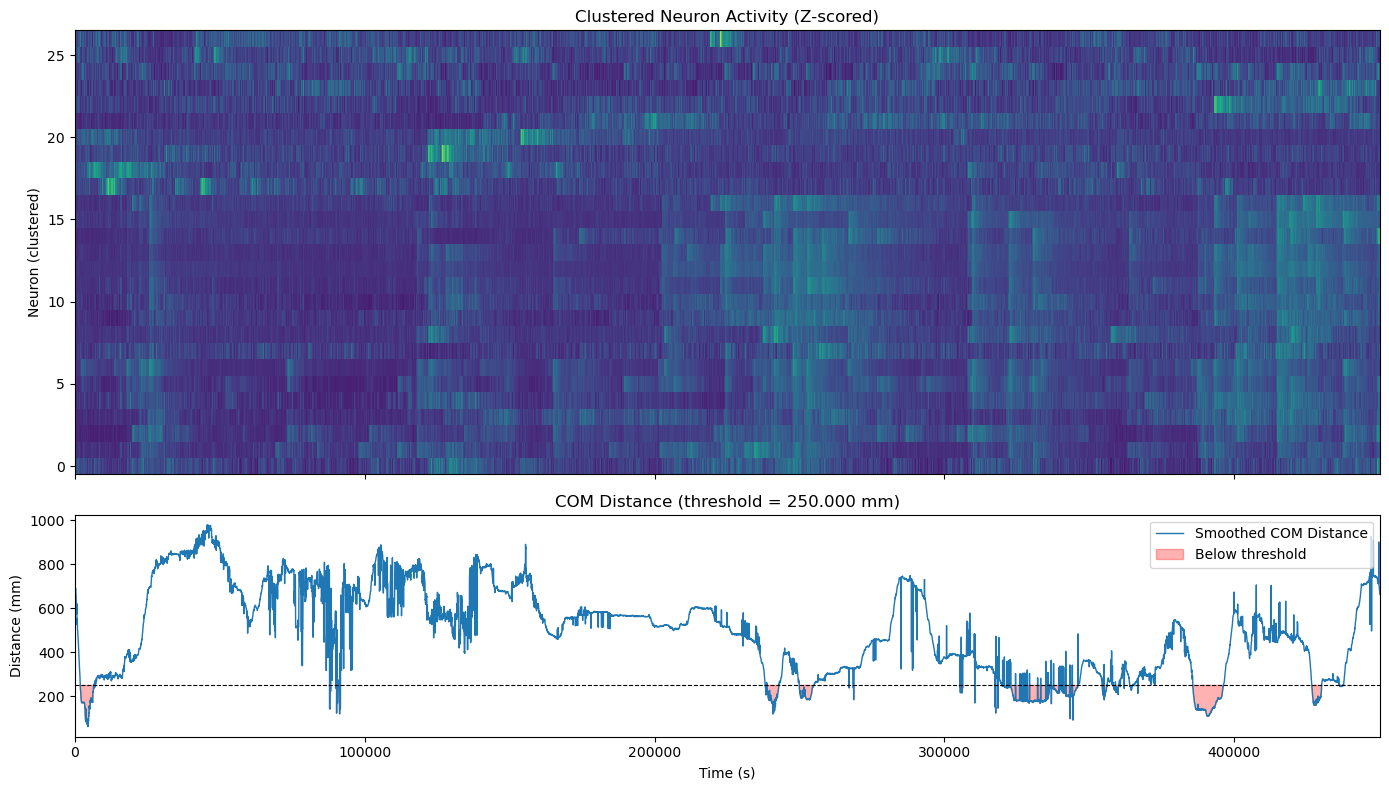

In [18]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import zscore
from sklearn.mixture import GaussianMixture

# ----------------------------------------------------------------------------
# 1. Load exclusion mapping
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_dict = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    如果 session_path 在排除字典里，就返回需要排除的神经元索引列表，否则返回空列表。
    """
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

# ----------------------------------------------------------------------------
# 2. Load session HDF5
# ----------------------------------------------------------------------------
def load_session_data(rec_path):
    """
    在 rec_path/MIR_Aligned 下寻找匹配的 .h5 文件，将其读入为 DataFrame 并添加一些额外列。
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 with aligned_predictions_with_ca_and_dF_F in {h5_dir}")
    hdf5_file_path = h5_files[0]

    df = pd.read_hdf(hdf5_file_path, key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']      = os.path.basename(norm_path)
    df['recording_date']  = os.path.basename(os.path.dirname(norm_path))
    df['experiment']      = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']    = rec_path
    df['file_path']       = hdf5_file_path
    return df

# ----------------------------------------------------------------------------
# 3. Process neuron activity
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict=None, manual_exclude_indices=None, apply_exclusion=True):
    """
    过滤低方差神经元、排除指定索引，并对剩余神经元的 dF/F 序列进行 z-score 标准化。
    返回：
      - normalized: 形状为 (n_kept_neurons, n_timepoints) 的 numpy 数组
      - filtered_cols: 保留下来的列名列表
      - df_reset: 重置了索引的 DataFrame 副本
    """
    if apply_exclusion:
        if manual_exclude_indices is not None:
            excluded = manual_exclude_indices
        elif exclude_dict is not None:
            excluded = get_excluded_neurons_for_session(df['session_path'].iloc[0], exclude_dict)
        else:
            excluded = []
    else:
        excluded = []

    # 构建要排除的 dF_F 列名集合
    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    activity = df[neuron_cols].values.T  # shape: (n_neurons, n_timepoints)
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5)         # 去掉最底部 5% 方差的神经元
    keep = variances > thresh
    filtered = activity[keep, :]
    filtered_cols = [col for i, col in enumerate(neuron_cols) if keep[i]]
    normalized = zscore(filtered, axis=1)
    df_reset = df.reset_index(drop=True)
    return normalized, filtered_cols, df_reset

# ----------------------------------------------------------------------------
# 4. Main plotting routine（支持手动阈值）
# ----------------------------------------------------------------------------
def plot_cluster_and_distance(df, exclude_dict=None, manual_exclude_indices=None,
                              apply_exclusion=True, distance_threshold=None):
    """
    只绘制两部分：
      1. 聚类后的神经元活动热图（仅保留高方差、不在排除列表的神经元，Z-score 标准化后层次聚类）
      2. COM 质心距离随时间变化，并在距离低于阈值时高亮
    distance_threshold: 如果提供，则直接使用该值作为“close/far”的阈值；否则使用 GMM 自动计算
    """
    # 第一步：处理神经元活动，得到标准化矩阵和列名
    neuron_norm, neuron_cols, df_new = process_neuron_activity(
        df, exclude_dict, manual_exclude_indices, apply_exclusion
    )

    df = df.reset_index()
    time = df['timestamp_ms_mini']

    # 计算 COM 距离
    com_prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com')})
    if len(com_prefixes) < 2:
        raise RuntimeError("至少需要两个 COM 前缀才能计算距离")

    p1, p2 = com_prefixes[0], com_prefixes[1]
    dx = df_new[f'{p1}_x'] - df_new[f'{p2}_x']
    dy = df_new[f'{p1}_y'] - df_new[f'{p2}_y']
    dz = df_new[f'{p1}_z'] - df_new[f'{p2}_z']
    dist = np.sqrt(dx**2 + dy**2 + dz**2)
    dist_sm = dist
    # dist_sm = dist.rolling(window=1, center=True).mean()

    # 如果用户给了 distance_threshold，就直接用；否则用 GMM 自动拟合
    if distance_threshold is None:
        dist_valid = dist_sm.dropna().values.reshape(-1, 1)
        if len(dist_valid) < 10:
            threshold = np.nanmedian(dist_sm)
        else:
            gmm = GaussianMixture(n_components=2, random_state=0)
            gmm.fit(dist_valid)
            means = np.sort(gmm.means_.flatten())
            threshold = np.mean(means)
    else:
        threshold = distance_threshold

    # 绘制
    fig, (ax_heatmap, ax_dist) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(14, 8),
        gridspec_kw={'height_ratios': [2, 1]},
        sharex=True
    )

    # 热图：层次聚类后的 neuron_norm
    if neuron_norm.size:
        Z = linkage(neuron_norm, method='ward')
        order = leaves_list(Z)
        data_ordered = neuron_norm[order, :]
        ax_heatmap.pcolormesh(time.values, np.arange(data_ordered.shape[0]), data_ordered,
                              cmap='viridis', shading='auto')
        ax_heatmap.set_ylabel('Neuron (clustered)')
        ax_heatmap.set_title('Clustered Neuron Activity (Z-scored)')
    else:
        ax_heatmap.text(0.5, 0.5, 'No neuron data after filtering',
                        transform=ax_heatmap.transAxes, ha='center')
        ax_heatmap.set_ylabel('Neuron (clustered)')
        ax_heatmap.set_title('Clustered Neuron Activity (Z-scored)')
    ax_heatmap.tick_params(labelbottom=False)

    # COM 距离随时间变化，并在低于阈值时高亮
    ax_dist.plot(time, dist_sm, label='Smoothed COM Distance', linewidth=1)
    ax_dist.set_ylabel('Distance (mm)')
    ax_dist.set_xlabel('Time (s)')
    ax_dist.set_title(f'COM Distance (threshold = {threshold:.3f} mm)')

    below_thresh = (dist_sm <= threshold)
    ax_dist.fill_between(time, dist_sm, threshold, where=below_thresh,
                         color='red', alpha=0.3, label='Below threshold')
    ax_dist.axhline(threshold, color='black', linestyle='--', linewidth=0.8)
    ax_dist.legend(loc='upper right')

    plt.tight_layout()
    plt.show(fig)

# ----------------------------------------------------------------------------
# 5. Example usage（传入手动阈值或留空让脚本自动计算）
# ----------------------------------------------------------------------------
session_paths = [
 "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
]

for path in session_paths:
    try:
        df_session = load_session_data(path)
        # 如果想用“手动阈值”，传入一个数字；若想自动计算，传 None
        plot_cluster_and_distance(df_session, exclude_dict=exclude_dict,
                                  apply_exclusion=True, distance_threshold=250.0)
    except Exception as e:
        print(f"Failed for session {path}: {e}")


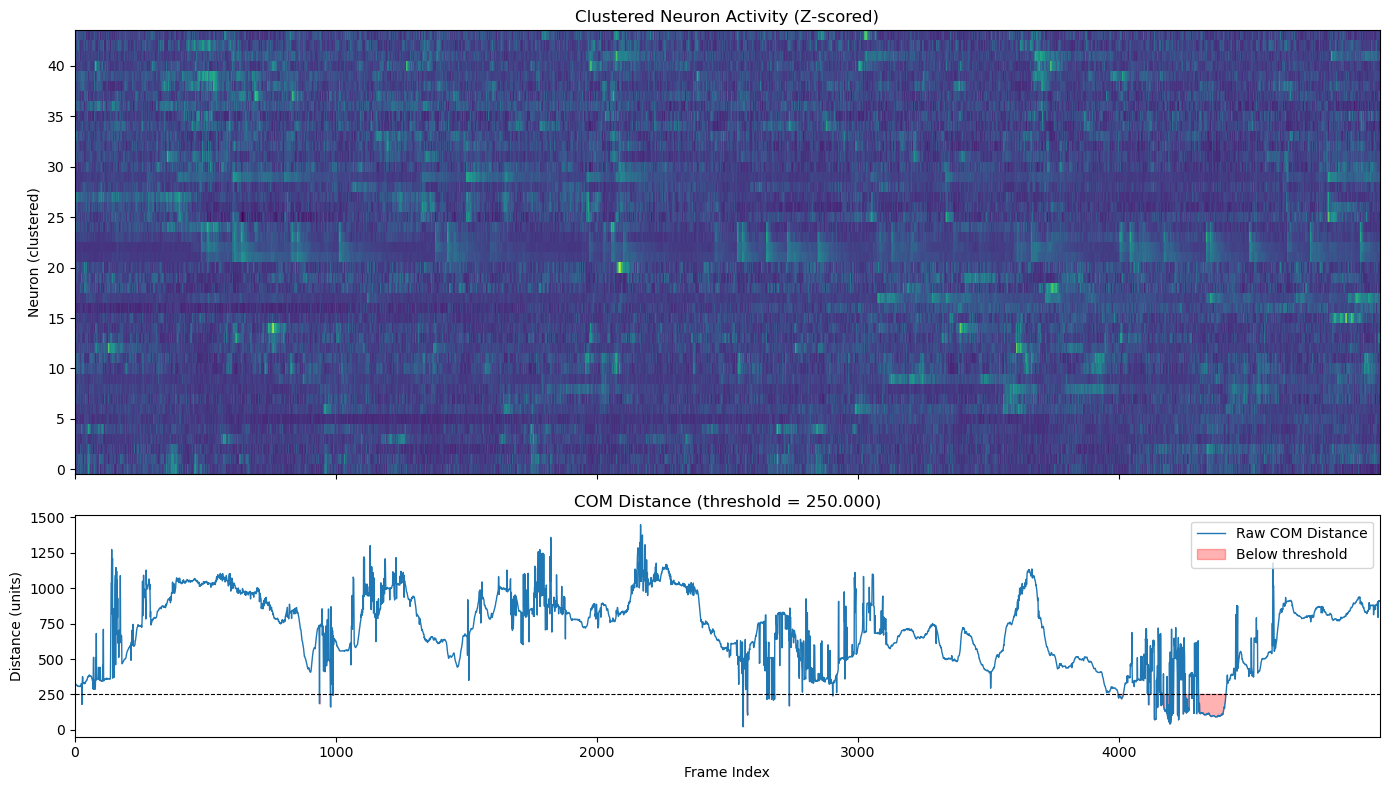

In [31]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import zscore
from sklearn.mixture import GaussianMixture

# ----------------------------------------------------------------------------
# 1. Load exclusion mapping
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_dict = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    如果 session_path 在排除字典里，就返回需要排除的神经元索引列表，否则返回空列表。
    """
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

# ----------------------------------------------------------------------------
# 2. Load session HDF5
# ----------------------------------------------------------------------------
def load_session_data(rec_path):
    """
    在 rec_path/MIR_Aligned 下寻找匹配的 .h5 文件，将其读入为 DataFrame 并添加一些额外列。
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 with aligned_predictions_with_ca_and_dF_F in {h5_dir}")
    hdf5_file_path = h5_files[0]

    df = pd.read_hdf(hdf5_file_path, key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']      = os.path.basename(norm_path)
    df['recording_date']  = os.path.basename(os.path.dirname(norm_path))
    df['experiment']      = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']    = rec_path
    df['file_path']       = hdf5_file_path
    return df

# ----------------------------------------------------------------------------
# 3. Process neuron activity
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict=None, manual_exclude_indices=None, apply_exclusion=True):
    """
    过滤低方差神经元、排除指定索引，并对剩余神经元的 dF/F 序列进行 z-score 标准化。
    返回：
      - normalized: 形状为 (n_kept_neurons, n_timepoints) 的 numpy 数组
      - filtered_cols: 保留下来的列名列表
      - df_reset: 重置了索引的 DataFrame 副本
    """
    if apply_exclusion:
        if manual_exclude_indices is not None:
            excluded = manual_exclude_indices
        elif exclude_dict is not None:
            excluded = get_excluded_neurons_for_session(df['session_path'].iloc[0], exclude_dict)
        else:
            excluded = []
    else:
        excluded = []

    # 构建要排除的 dF_F 列名集合
    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    activity = df[neuron_cols].values.T  # shape: (n_neurons, n_timepoints)
    variances = np.var(activity, axis=1)
    thresh_var = np.percentile(variances, 5)  # 去掉最底部 5% 方差的神经元
    keep = variances > thresh_var
    filtered = activity[keep, :]
    filtered_cols = [col for i, col in enumerate(neuron_cols) if keep[i]]
    normalized = zscore(filtered, axis=1)
    df_reset = df.reset_index(drop=True)
    return normalized, filtered_cols, df_reset

# ----------------------------------------------------------------------------
# 4. Main plotting routine（不做平滑，可选绘制帧数上限）
# ----------------------------------------------------------------------------
def plot_cluster_and_distance(
    df,
    exclude_dict=None,
    manual_exclude_indices=None,
    apply_exclusion=True,
    distance_threshold=None,
    max_frame=None
):
    """
    绘制两部分：
      1. 聚类后的神经元活动热图（仅保留高方差、不在排除列表的神经元，Z-score 标准化后层次聚类）
      2. COM 质心距离随时间变化，并在距离低于阈值时高亮

    参数
    ----
    df: pandas.DataFrame
        从 load_session_data 得到的 DataFrame，其中包含“com*_x/y/z”列和“timestamp_ms_mini”列
    exclude_dict: dict 或 None
        排除哪些神经元的映射字典
    manual_exclude_indices: list 或 None
        手动指定要排除的神经元索引
    apply_exclusion: bool
        是否应用排除
    distance_threshold: float 或 None
        如果为 float，则直接使用该阈值划分 close/far；如果为 None，则按 GMM 自动拟合
    max_frame: int 或 None
        如果为 int，则只绘制到第 max_frame 帧（frame index 从 0 开始）；否则绘制所有帧
    """
    # —— 第一步：处理神经元活动
    neuron_norm, neuron_cols, df_new = process_neuron_activity(
        df, exclude_dict, manual_exclude_indices, apply_exclusion
    )

    df = df.reset_index()
    time_ms = df['timestamp_ms_mini']

    # —— 第二步：计算 COM 距离（逐帧，无平滑）
    # 先找出所有以 'com' 开头的列，确认前缀
    com_prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com')})
    if len(com_prefixes) < 2:
        raise RuntimeError("至少需要两个 COM 前缀才能计算距离")
    # 显式选择前两项（确保 p1/p2 对应两只动物）
    p1, p2 = com_prefixes[0], com_prefixes[1]

    dx = df_new[f'{p1}_x'].values - df_new[f'{p2}_x'].values
    dy = df_new[f'{p1}_y'].values - df_new[f'{p2}_y'].values
    dz = df_new[f'{p1}_z'].values - df_new[f'{p2}_z'].values
    dist = np.sqrt(dx**2 + dy**2 + dz**2)  # 原始逐帧距离，numpy 数组，长度 = n_timepoints

    # —— 第三步：确定阈值
    if distance_threshold is None:
        # 用 GMM 自动拟合
        valid_idx = ~np.isnan(dist)
        dist_valid = dist[valid_idx].reshape(-1, 1)
        if len(dist_valid) < 10:
            threshold = np.nanmedian(dist)
        else:
            gmm = GaussianMixture(n_components=2, random_state=0)
            gmm.fit(dist_valid)
            means = np.sort(gmm.means_.flatten())
            threshold = np.mean(means)
    else:
        threshold = distance_threshold

    # —— 第四步：处理“绘制帧数上限”逻辑
    n_frames_total = len(dist)
    if max_frame is not None:
        # 限制 max_frame 在合理范围内
        max_frame = int(max_frame)
        if max_frame < 1:
            raise ValueError("max_frame 必须为正整数或 None")
        end_idx = min(max_frame, n_frames_total)
    else:
        end_idx = n_frames_total

    # 切片后的时间数组和距离数组
    time_ms_plot = time_ms[:end_idx]
    dist_plot    = dist[:end_idx]

    # 对应的“低于阈值”掩码
    below_thresh = dist_plot <= threshold

    # —— 第五步：绘制热图与距离图
    fig, (ax_heatmap, ax_dist) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(14, 8),
        gridspec_kw={'height_ratios': [2, 1]},
        sharex=True
    )

    # 5.1 热图部分：层次聚类 neuron_norm
    if neuron_norm.size:
        Z = linkage(neuron_norm, method='ward')
        order = leaves_list(Z)
        data_ordered = neuron_norm[order, :]
        # 数据切片（只取前 end_idx 列，对应前 end_idx 帧）
        data_ordered = data_ordered[:, :end_idx]
        # 横坐标用帧索引 [0, 1, 2, …, end_idx-1]
        frames = np.arange(end_idx)
        ax_heatmap.pcolormesh(
            frames,                         # x 轴：帧索引
            np.arange(data_ordered.shape[0]),  # y 轴：聚类后神经元索引
            data_ordered,                   # 热图数据
            cmap='viridis',
            shading='auto'
        )
        ax_heatmap.set_ylabel('Neuron (clustered)')
        ax_heatmap.set_title('Clustered Neuron Activity (Z-scored)')
    else:
        ax_heatmap.text(
            0.5, 0.5, 'No neuron data after filtering',
            transform=ax_heatmap.transAxes,
            ha='center'
        )
        ax_heatmap.set_ylabel('Neuron (clustered)')
        ax_heatmap.set_title('Clustered Neuron Activity (Z-scored)')
    ax_heatmap.tick_params(labelbottom=False)

    # 5.2 距离时序图：用帧索引对应横坐标
    frames_plot = np.arange(end_idx)
    ax_dist.plot(frames_plot, dist_plot, label='Raw COM Distance', linewidth=1)
    ax_dist.set_ylabel('Distance (units)')
    ax_dist.set_xlabel('Frame Index')
    ax_dist.set_title(f'COM Distance (threshold = {threshold:.3f})')

    # 在低于阈值部分高亮
    ax_dist.fill_between(
        frames_plot,
        dist_plot,
        threshold,
        where=below_thresh,
        color='red',
        alpha=0.3,
        label='Below threshold'
    )
    ax_dist.axhline(threshold, color='black', linestyle='--', linewidth=0.8)
    ax_dist.legend(loc='upper right')

    plt.tight_layout()
    plt.show(fig)

# ----------------------------------------------------------------------------
# 5. 示例调用：指定 max_frame 或者留空
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    session_paths = [
#  "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
]

    for path in session_paths:
        try:
            df_session = load_session_data(path)
            # 只画前 500 帧（如果想画全部，可把 max_frame=None 或直接不传该参数）
            plot_cluster_and_distance(
                df_session,
                exclude_dict=exclude_dict,
                apply_exclusion=True,
                distance_threshold=250.0,  # 如果想自动计算，请传 None
                max_frame=5000
            )
        except Exception as e:
            print(f"Failed for session {path}: {e}")


In [ ]:
    # # 保存图像到 MIR_Aligned 文件夹
    # save_dir       = os.path.join(df_new['session_path'].iloc[0], 'MIR_Aligned')
    # os.makedirs(save_dir, exist_ok=True)
    # session_name   = os.path.basename(os.path.normpath(df_new['session_path'].iloc[0]))
    # pred_name      = os.path.splitext(os.path.basename(df_new['file_path'].iloc[0]))[0]
    # output_filename = f"cluster_distance_plot_{session_name}_{pred_name}.png"
    # save_path = os.path.join(save_dir, output_filename)
    # fig.savefig(save_path, dpi=300)
    # print(f"Figure saved at: {save_path}")
    # plt.close(fig)